# ResNet

> Neural net model

In [ ]:
#| default_exp models.resnet

In [80]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [72]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch_lr_finder import LRFinder

from omegaconf import OmegaConf
from hydra.utils import instantiate

from matplotlib import pyplot as plt

from nimrod.models.conv import ConvLayer
from nimrod.utils import get_device, set_seed

from typing import List
import logging

In [68]:
logger = logging.getLogger(__name__)
set_seed()

Seed set to 42


## Res Block

In [84]:
#| export
class ResBlock(nn.Module):
    """ResNet basic block with optional downsampling.
    This block implements the basic building block of ResNet architecture,
    consisting of two convolutional layers with a residual connection.
    The block can optionally downsample the input using strided convolution
    and average pooling.

    Parameters
    ----------
    in_channels : int
        Number of input channels
    out_channels : int
        Number of output channels
    stride : int, optional
        Stride for the second convolution and pooling, by default 1
    kernel_size : int, optional
        Kernel size for the convolutions, by default 3
    
    Notes
    -----
    The block performs the following operations:
    1. First convolution with kernel_size and stride=1
    2. Second convolution with kernel_size and specified stride
    3. Identity/1x1 conv on residual path depending on channel dimensions
    4. Average pooling on residual path if stride > 1
    5. ReLU activation after element-wise addition
    The output dimensions are determined by the stride parameter:
    - If stride=1: output has same spatial dimensions as input
    - If stride=2: output spatial dimensions are halved
    """


    def __init__(
            self,
            in_channels: int, # Number of input channels
            out_channels: int, # Number of output channels
            stride: int = 1, # Stride for the second convolution and pooling
            kernel_size:int = 3 # Kernel size for the convolutions
            ):
        
        super().__init__()

        conv_ = nn.ModuleList()
        conv_.append(ConvLayer(in_channels, out_channels, stride=1, kernel_size=kernel_size))
        conv_.append(ConvLayer(out_channels, out_channels, stride=stride, activation=None))
        self.conv = nn.Sequential(*conv_)


        if in_channels == out_channels:
            self.id = nn.Identity()
        else:
            self.id = ConvLayer(in_channels, out_channels, stride=1, kernel_size=1, activation=None)

        if stride == 1:
            self.pool = nn.Identity()
        else:
            self.pool = nn.AvgPool2d(2, ceil_mode=True)
        self.act = nn.ReLU()
        
    def forward(self, x):
        return self.act(self.conv(x) + self.id(self.pool(x)))

In [85]:
show_doc(ResBlock)

---

### ResBlock

>      ResBlock (in_channels:int, out_channels:int, stride:int=1,
>                kernel_size:int=3)

*ResNet basic block with optional downsampling.
This block implements the basic building block of ResNet architecture,
consisting of two convolutional layers with a residual connection.
The block can optionally downsample the input using strided convolution
and average pooling.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| in_channels | int |  | Number of input channels |
| out_channels | int |  | Number of output channels |
| stride | int | 1 | Stride for the second convolution and pooling |
| kernel_size | int | 3 | Kernel size for the convolutions |

### Usage

In [41]:
resblock = ResBlock(1, 8)
x = torch.rand(5, 1, 28, 28)
print(x.shape)
resblock(x).shape

[00:11:18] WARNING - setting conv bias to False as Batchnorm is used
[00:11:18] WARNING - setting conv bias to False as Batchnorm is used
[00:11:18] WARNING - setting conv bias to False as Batchnorm is used


torch.Size([5, 1, 28, 28])


torch.Size([5, 8, 28, 28])

## ResNet

In [94]:
#| export 
class ResNet(nn.Module):
    """A simple implementation of a ResNet-like neural network.

    Parameters
    ----------
    n_features : List[int], optional
        A list of integers representing the number of features (channels) at each layer. 
        Default is [1, 8, 16, 32, 64, 128, 256].
    num_classes : int, optional
        The number of output classes. Default is 10.
    """

    def __init__(
            self,
            n_features:List[int]=[1, 8, 16, 32, 64, 128, 256], # channel/feature expansion
            num_classes:int=10, # num_classes
        ):

        super().__init__()

        layers = nn.ModuleList()
        layers.append(ResBlock(n_features[0], n_features[1], stride=1))

        for i in range(1, len(n_features)-1):
            res = ResBlock(n_features[i], n_features[i+1], stride=2)
            layers.append(res)

        layers += [nn.Flatten(), nn.Linear(n_features[-1], num_classes, bias=False), nn.BatchNorm1d(num_classes)]


        self.nnet = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)


In [95]:
show_doc(ResNet)

---

### ResNet

>      ResNet (n_features:List[int]=[1, 8, 16, 32, 64, 128, 256],
>              num_classes:int=10)

*A simple implementation of a ResNet-like neural network.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| n_features | List | [1, 8, 16, 32, 64, 128, 256] | channel/feature expansion |
| num_classes | int | 10 | num_classes |

### Usage

In [60]:
x = torch.rand(5, 1, 28, 28)
model = ResNet()
model(x).shape

[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv bias to False as Batchnorm is used
[00:35:14] WARNING - setting conv 

torch.Size([5, 10])

## Training

In [70]:
#| notest

# data module config
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')

BATCH_SIZE = 512
datamodule = instantiate(cfg, batch_size=BATCH_SIZE, num_workers=20)
datamodule.prepare_data()
datamodule.setup()

# one data point 
X,y = datamodule.test_ds[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.train_ds))
print(len(datamodule.train_ds) // BATCH_SIZE)

[00:52:03] INFO - Init ImageDataModule for fashion_mnist
[00:52:13] INFO - split train into train/val [0.8, 0.2]
[00:52:13] INFO - train: 48000 val: 12000, test: 10000


X (C,H,W):  torch.Size([1, 32, 32]) y:  9
XX (B,C,H,W):  torch.Size([512, 1, 32, 32]) YY:  torch.Size([512])
48000
93


[01:03:58] INFO - Using device: cuda
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is used
[01:03:58] WARNING - setting conv bias to False as Batchnorm is us

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.33E-05


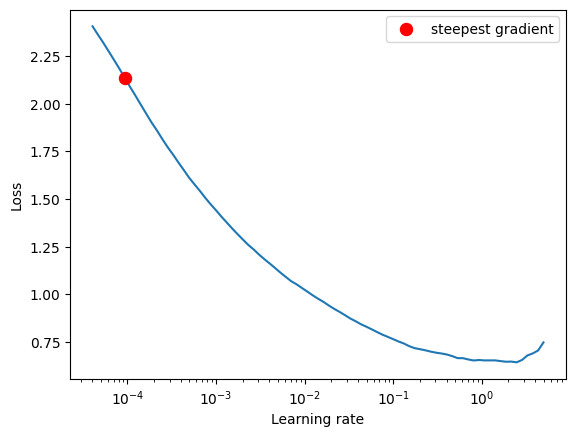

Suggested lr: 9.326033468832202e-05


In [77]:
#| notest
device = get_device()
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #, weight_decay=1e-5)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-5,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

size training set: 48000, bs: 512, steps/epoch: 93, total steps: 465
CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 10.5 μs
Loss 2.5942, Current LR: 0.0000093368, Step: 1/465
Epoch 1: Last training Loss 0.8256, Last Eval loss 0.8696 Accuracy = 78.29% Best Accuracy: 79.39
Loss 0.8176, Current LR: 0.0000744355, Step: 95/465
Epoch 2: Last training Loss 0.7054, Last Eval loss 0.7248 Accuracy = 84.31% Best Accuracy: 85.55
Loss 0.6581, Current LR: 0.0000878304, Step: 189/465
Epoch 3: Last training Loss 0.6297, Last Eval loss 0.6788 Accuracy = 86.06% Best Accuracy: 87.50
Loss 0.5701, Current LR: 0.0000548017, Step: 283/465
Epoch 4: Last training Loss 0.6523, Last Eval loss 0.6495 Accuracy = 86.79% Best Accuracy: 87.99
Loss 0.5393, Current LR: 0.0000154962, Step: 377/465
Reached total steps: 465/465
Epoch 5: Last training Loss 0.5910, Last Eval loss 0.6488 Accuracy = 86.93% Best Accuracy: 88.05


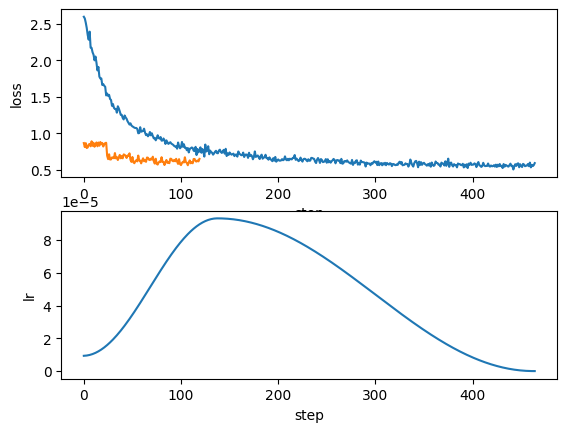

In [78]:
#| notest

# # data module config
# cfg_dm = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
# cfg_dm.batch_size = 512
# datamodule = instantiate(cfg_dm)
# datamodule.prepare_data()
# datamodule.setup()

# device = 'cpu'
# print(device)
# cfg_mdl = OmegaConf.load('../config/model/image/convnet.yaml')
# convnet = instantiate(cfg_mdl.batchnorm)
# model = convnet.to(device)

N_EPOCHS = 5

# lr_found = 7e-3 # from lr finder

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.train_ds) // BATCH_SIZE
total_steps = steps_per_epoch* N_EPOCHS
print(f"size training set: {len(datamodule.train_ds)}, bs: {BATCH_SIZE}, steps/epoch: {steps_per_epoch}, total steps: {total_steps}")
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.train_ds) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

################################
%time

lrs = []
current_step = 0
train_loss_history = []
eval_loss_history = []
avg_train_loss_hist = []
avg_eval_loss_hist = []
max_acc = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
        train_loss_history.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.val_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # eval loss
            eval_loss = criterion(outputs, labels)
            eval_loss_history.append(eval_loss.item())
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()
            acc = 100 * correct / total
            if acc > max_acc:
                max_acc = acc

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Last training Loss {loss.item():.4f}, Last Eval loss {eval_loss.item():.4f} Accuracy = {100 * correct / total:.2f}% Best Accuracy: {max_acc:.2f}")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')

###################
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(train_loss_history)
plt.plot(eval_loss_history)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()